In [1]:
import random

import numpy as np

import torch
torch.set_default_device('cuda')
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
import torchvision.transforms.functional

from PIL import Image
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class ImagenetteDataset(object):
    def __init__(self, crop_size=320, validation=False):
        self.crop_size = crop_size
        self.validation = validation
        
        self.folder = Path('imagenette2/train') if not self.validation else Path('imagenette2/val')
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                        'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
        self.labels_map = {
            0: 'tench', 
            1: 'english springer', 
            2: 'cassette player', 
            3: 'chain saw', 
            4: 'church', 
            5: 'French horn', 
            6: 'garbage truck', 
            7: 'gas pump', 
            8: 'golf ball', 
            9: 'parachute',
         }

        # collect image paths
        self.images = []
        for cls in self.classes:
            cls_images = list(self.folder.glob(cls + '/*.JPEG'))
            self.images.extend(cls_images)
        
        self.random_resize = torchvision.transforms.RandomResizedCrop(self.crop_size)  # training
        self.center_resize = torchvision.transforms.CenterCrop(self.crop_size)  # validation
        # normalize as human eye is not equally sensitive to colors (but ML models should)
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # used in most datasets (specific)
        
    def __getitem__(self, index):
        # get the image and corresponing label
        image_fname = self.images[index]
        image = Image.open(image_fname)
        label = image_fname.parent.stem
        label = self.classes.index(label)

        # perform transforms
        if not self.validation: 
            image = self.random_resize(image)
        else: 
            image = self.center_resize(image)
        
        image = torchvision.transforms.functional.to_tensor(image)
        if image.shape[0] == 1: image = image.expand(3, self.crop_size, self.crop_size)
        image = self.normalize(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [3]:
train_dataset = ImagenetteDataset(224, False)
print(f"Training set size: {len(train_dataset)} images")
test_dataset = ImagenetteDataset(224, True)
print(f"Validation set size: {len(test_dataset)} images")

Training set size: 9469 images
Validation set size: 3925 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping i

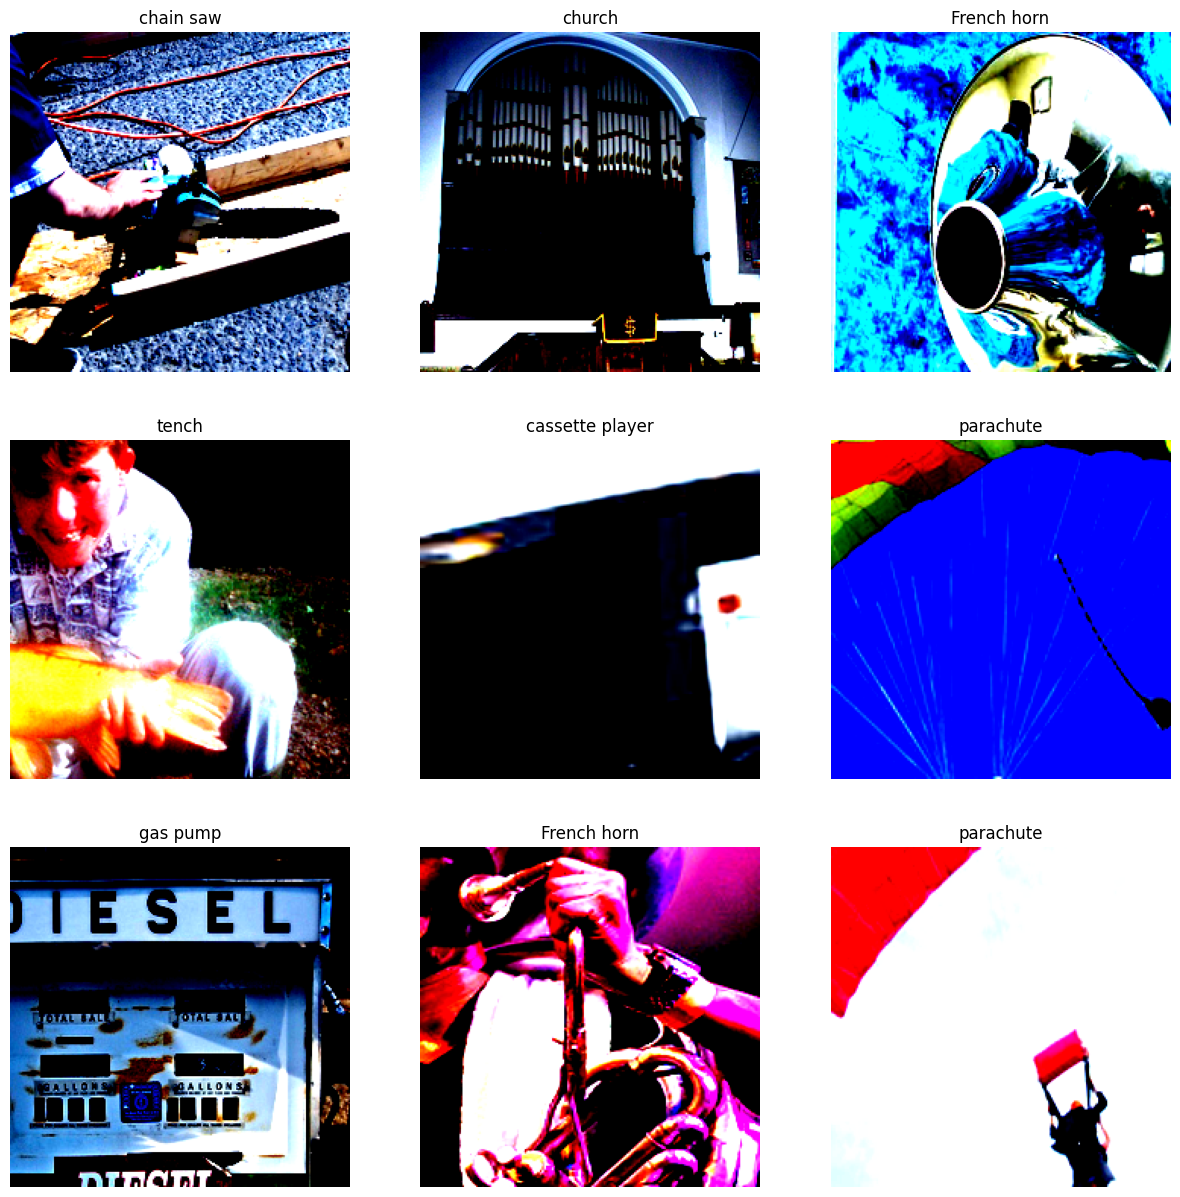

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for y in range(3):
    for x in range(3):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]
        ax[y, x].imshow(img.numpy().transpose(1,2,0))
        ax[y, x].set_axis_off()
        ax[y, x].set_title(train_dataset.labels_map[label])

plt.show();

In [5]:
# initialize the dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
next(iter(train_loader))

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# Load the model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).cuda()
model.eval()

In [ ]:
correct, total, loss = 0, 0, 0
with torch.no_grad():
    for (images, labels) in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
print(correct / total)